In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/curlew-sound-3.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-48.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-39.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/crow-cawing-sound-effect-9.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-5.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-4.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/crickets-chirping-crickets-sound-0.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-29.wav
/kaggle/input/z

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
capuchin_file='/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC433953-10.wav'
notCapuchin_file = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-42.wav'

In [4]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype = tf.int64)  # Converting to the dtypes
    
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) # sample rate conversion
    
    return wav

In [5]:
wave = load_wav_16k_mono(capuchin_file)
nwave = load_wav_16k_mono(notCapuchin_file)

2022-12-22 18:24:13.230221: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-22 18:24:13.388778: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-12-22 18:24:13.655320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


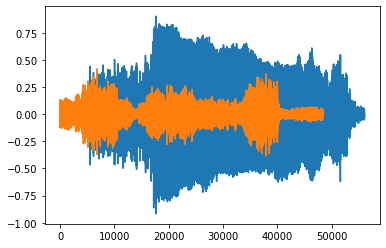

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [7]:
pos= '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'
neg= '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips'

In [8]:
pos = tf.data.Dataset.list_files(pos+'/*.wav')
neg = tf.data.Dataset.list_files(neg+'/*.wav')

In [9]:
pos.as_numpy_iterator().next()

b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC520626-0.wav'

In [10]:
positives= tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives= tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data= positives.concatenate(negatives)

In [11]:
data.as_numpy_iterator().next()

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC388470-5.wav',
 1.0)

# Determine Average Length of Capuchin call

In [12]:
length = []
for file in os.listdir('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'):
    tensor_wave = load_wav_16k_mono(os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips', file))
    length.append(len(tensor_wave))

In [13]:
tf.math.reduce_mean(length)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [14]:
tf.math.reduce_min(length)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [15]:
tf.math.reduce_max(length)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# Converting to Spectrogram

In [16]:
def preprocess (file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length= 320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [17]:
wav = load_wav_16k_mono(capuchin_file)
wav = wav[:48000]
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav], 0)
spectrogram = tf.signal.stft(wav, frame_length= 320, frame_step=32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram, axis=2)

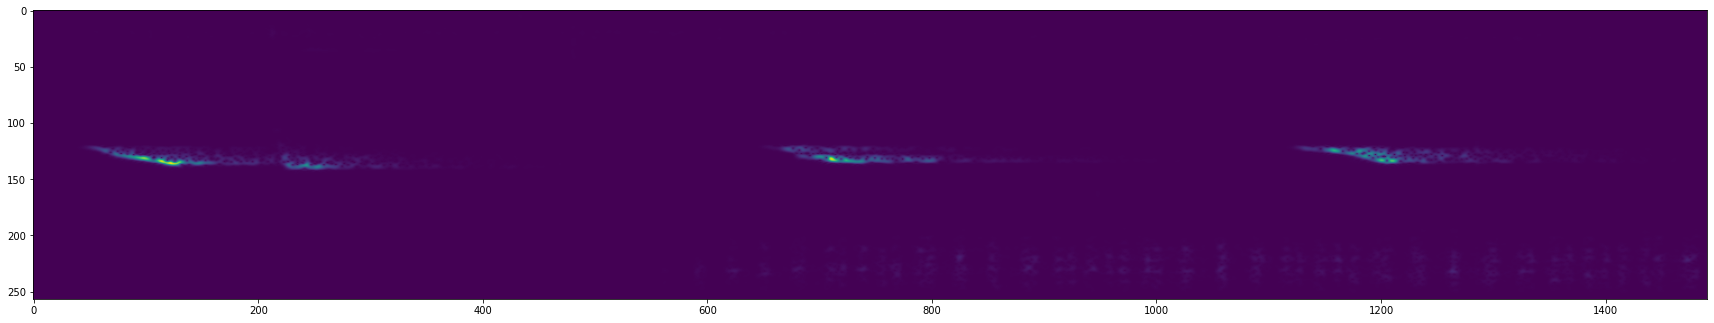

In [18]:
filepath, label =negatives.shuffle(buffer_size = 1000).as_numpy_iterator().next()
spectrogram, label =preprocess(filepath, label)
# print(spectrogram)
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

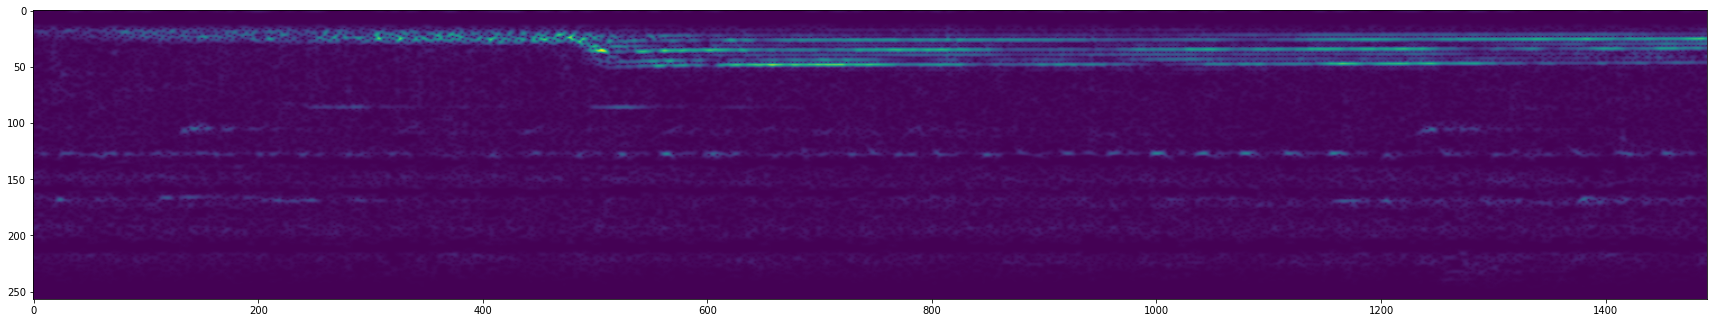

In [19]:
filepath, label =positives.shuffle(buffer_size = 1000).as_numpy_iterator().next()
spectrogram, label =preprocess(filepath, label)
# print(spectrogram)
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Train test Split

In [20]:
data = data.map(preprocess)
data=data.cache() 

data = data.shuffle(buffer_size=1000)

data=data.batch(16)
data = data.prefetch(8)

In [21]:
len(data)

51

In [22]:
train = data.take(36)
test = data.skip(36).take(15)

In [23]:
sample, label = train.as_numpy_iterator().next()
sample.shape

2022-12-22 18:24:40.291565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 350 of 1000
2022-12-22 18:24:50.314262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 688 of 1000
2022-12-22 18:24:54.039658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


(16, 1491, 257, 1)

above shows that there are 16 samples in one batch each of (1491, 257) and 1 dimension

In [24]:
label

array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

# Build Deep Learning Model

In [25]:
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [26]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape= (1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 16)     160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1487, 253, 16)     2320      
_________________________________________________________________
flatten (Flatten)            (None, 6019376)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               770480256 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


# Fit model

In [29]:
hist= model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 172s 5s/step - loss: 5.9673 - recall: 0.9060 - precision: 0.8438 - val_loss: 0.2648 - val_recall: 0.9683 - val_precision: 0.9385
Epoch 2/4
36/36 [==============================] - 162s 5s/step - loss: 0.0598 - recall: 0.9748 - precision: 0.9688 - val_loss: 0.3008 - val_recall: 0.8841 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 162s 4s/step - loss: 0.0765 - recall: 0.9789 - precision: 0.9720 - val_loss: 7.9932e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 170s 5s/step - loss: 0.0276 - recall: 1.0000 - precision: 0.9936 - val_loss: 0.0116 - val_recall: 0.9853 - val_precision: 1.0000


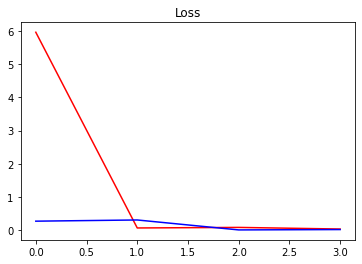

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [31]:
hist.history

{'loss': [5.967306613922119,
  0.05983312427997589,
  0.07647927105426788,
  0.027616266161203384],
 'recall': [0.9060402512550354, 0.9748427867889404, 0.9788732528686523, 1.0],
 'precision': [0.84375, 0.96875, 0.9720279574394226, 0.993630588054657],
 'val_loss': [0.26477158069610596,
  0.300828218460083,
  0.0007993222097866237,
  0.01164989173412323],
 'val_recall': [0.9682539701461792,
  0.8840579986572266,
  1.0,
  0.9852941036224365],
 'val_precision': [0.9384615421295166, 1.0, 1.0, 1.0]}

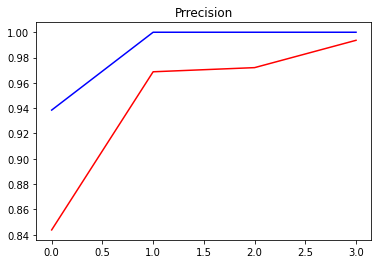

In [32]:
plt.title('Prrecision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

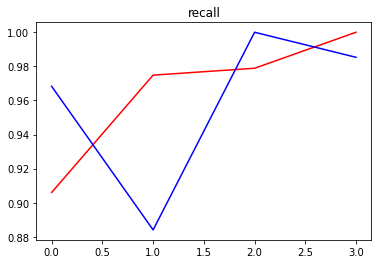

In [33]:
plt.title('recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [34]:
x_test, y_test = test.as_numpy_iterator().next()

In [35]:
yhat = model.predict(x_test)

In [36]:
y_test

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [37]:
[1 if predict > 0.5 else 0 for predict in yhat]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]

# On to the Forest Recording

In [38]:
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1)/2   #adding the two channels and taking the average of both, thus reducing it to a single channel value
    
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out = 16000)
    
    return wav

In [39]:
mp3_file = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_76.mp3'

In [40]:
wav = load_mp3_16k_mono(mp3_file)

In [41]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [42]:
len(audio_slices)

60

In [43]:
samples, index = audio_slices.as_numpy_iterator().next()

In [44]:
samples.shape

(1, 48000)

In [45]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav, frame_length= 320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [46]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(16)

In [47]:
yhat = model.predict(audio_slices)

In [48]:
yhat= [1 if prediction>0.9 else 0 for prediction in yhat]

In [49]:
len(yhat)

60

In [50]:
yhat

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [51]:
from itertools import groupby


In [52]:
yhat=[key for key, group in groupby(yhat)]

In [53]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [54]:

calls = tf.math.reduce_sum(yhat).numpy()
calls

0

# Make prodections

In [55]:
results = {}
for file in os.listdir('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings'):
    FILEPATH = os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    results[file] = yhat

In [56]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if predict>0.9 else 0 for predict in logits]
class_preds

{'recording_76.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_62.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_48.mp3': [0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_44.mp3': [0,
  0,
  0,
  

In [57]:
postprocessed ={}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_76.mp3': 0,
 'recording_62.mp3': 0,
 'recording_48.mp3': 4,
 'recording_44.mp3': 1,
 'recording_45.mp3': 3,
 'recording_06.mp3': 8,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 3,
 'recording_17.mp3': 3,
 'recording_65.mp3': 4,
 'recording_74.mp3': 0,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 2,
 'recording_37.mp3': 3,
 'recording_64.mp3': 3,
 'recording_39.mp3': 2,
 'recording_04.mp3': 7,
 'recording_28.mp3': 12,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 3,
 'recording_12.mp3': 0,
 'recording_59.mp3': 6,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 8,
 'recording_86.mp3': 6,
 'recording_47.mp3': 6,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 13,
 'recording_51.mp3': 3,
 'recording_35.mp3': 0,
 'recording_81.mp3': 5,
 'recording_30.mp3': 1,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recording_46